In [1]:
# importing the libraries
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from scipy.stats import kurtosis, skew
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.naive_bayes import GaussianNB
from scikitplot.metrics import plot_precision_recall
import pickle
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

In [2]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Reading the first data file into dataframe
data = arff.loadarff('datasets/1year.arff')
df = pd.DataFrame(data[0])

# Reading the second data file into dataframe
data2 = arff.loadarff('datasets/2year.arff')
df2 = pd.DataFrame(data2[0])

# Reading the third data file into dataframe
data3 = arff.loadarff('datasets/3year.arff')
df3 = pd.DataFrame(data3[0])

# Reading the fourth data file into dataframe
data4 = arff.loadarff('datasets/4year.arff')
df4 = pd.DataFrame(data4[0])

# Reading the fifth data file into dataframe
data5 = arff.loadarff('datasets/5year.arff')
df5 = pd.DataFrame(data5[0])

In [4]:
# Making one dataframe by appending the 4 dataframe to the first one
df = df.append([df2, df3, df4, df5], ignore_index=True)
len(df)

43405

In [5]:
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [6]:
df['class'] = df['class'].astype('int')

In [7]:
# Drop duplicates
df.drop_duplicates(keep=False, inplace=True)

In [8]:
# Look at a few rows of the bankruptcy file. I can see a handful of missing data already!
df.sample(5)

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
42298,0.225010,0.541070,0.204590,1.47220,6.8001,0.31209,0.225010,0.84818,1.83490,0.45893,...,0.138620,0.490300,0.87820,0.00000,10.605,4.4227,86.193,4.2347,5.06720,0
4408,0.006771,0.534840,-0.130760,0.72592,-69.1150,0.03316,0.005468,0.75383,1.00380,0.40318,...,0.003788,0.016794,0.99621,0.14326,16.146,5.2686,138.040,2.6441,1.92980,0
37864,0.046657,0.227900,0.023984,1.31760,-16.8710,0.25949,0.057348,3.28110,1.14510,0.74776,...,0.126730,0.062396,0.87327,0.20377,13.022,17.0420,53.510,6.8212,0.57211,0
37564,1.183700,0.044045,0.528200,12.99200,1017.0000,-0.23505,1.183700,21.70400,0.27782,0.95595,...,0.359150,1.238300,0.71127,0.00000,11.663,11.0630,57.866,6.3076,0.64948,0
33855,-0.304870,1.232200,-0.569440,0.53785,-84.5710,-0.55127,-0.304870,-0.18841,2.86410,-0.23216,...,-0.097809,1.313200,1.10610,0.00000,24.678,5.8563,157.030,2.3244,8.49140,0


In [9]:
# Get the number of missing data points per column
missing_values_count = df.isnull().sum()
missing_values_count

Attr1       8
Attr2       8
Attr3       8
Attr4     132
Attr5      89
         ... 
Attr61    100
Attr62    123
Attr63    132
Attr64    796
class       0
Length: 65, dtype: int64

In [10]:
# How many total missing values do we have?
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
print(f"The percent of the missing data is: {total_missing / total_cells * 100:.2f}%")

The percent of the missing data is: 1.47%


In [11]:
# Getting the mean values of the dataframe columns
mean_values = df.mean()

In [12]:
# Filling the missing data by mean values
df = df.fillna(mean_values)

In order to fill the nan values of the dataframe first I get the mean value for each column by (df.mean()) method and after that filling the nan values by the mean of each column

The second approach is to drop the rows which contains nan values, but I found that it will drop around 23000 records more than the half of the data

In [13]:
# Getting the number of missing data points per column after filling the nan values
missing_values_count_after_filling_NAN_values = df.isnull().sum()
missing_values_count_after_filling_NAN_values

Attr1     0
Attr2     0
Attr3     0
Attr4     0
Attr5     0
         ..
Attr61    0
Attr62    0
Attr63    0
Attr64    0
class     0
Length: 65, dtype: int64

In [14]:
df['class'].value_counts()

0    40528
1     2075
Name: class, dtype: int64

Text(0.5, 1.0, 'Number of appearances in dataset')

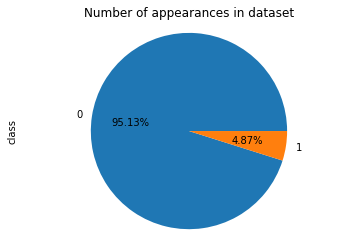

In [15]:
# Make a pie chart
df['class'].value_counts().plot(kind='pie', autopct='%1.2f%%')
plt.axis('equal')
plt.title('Number of appearances in dataset')

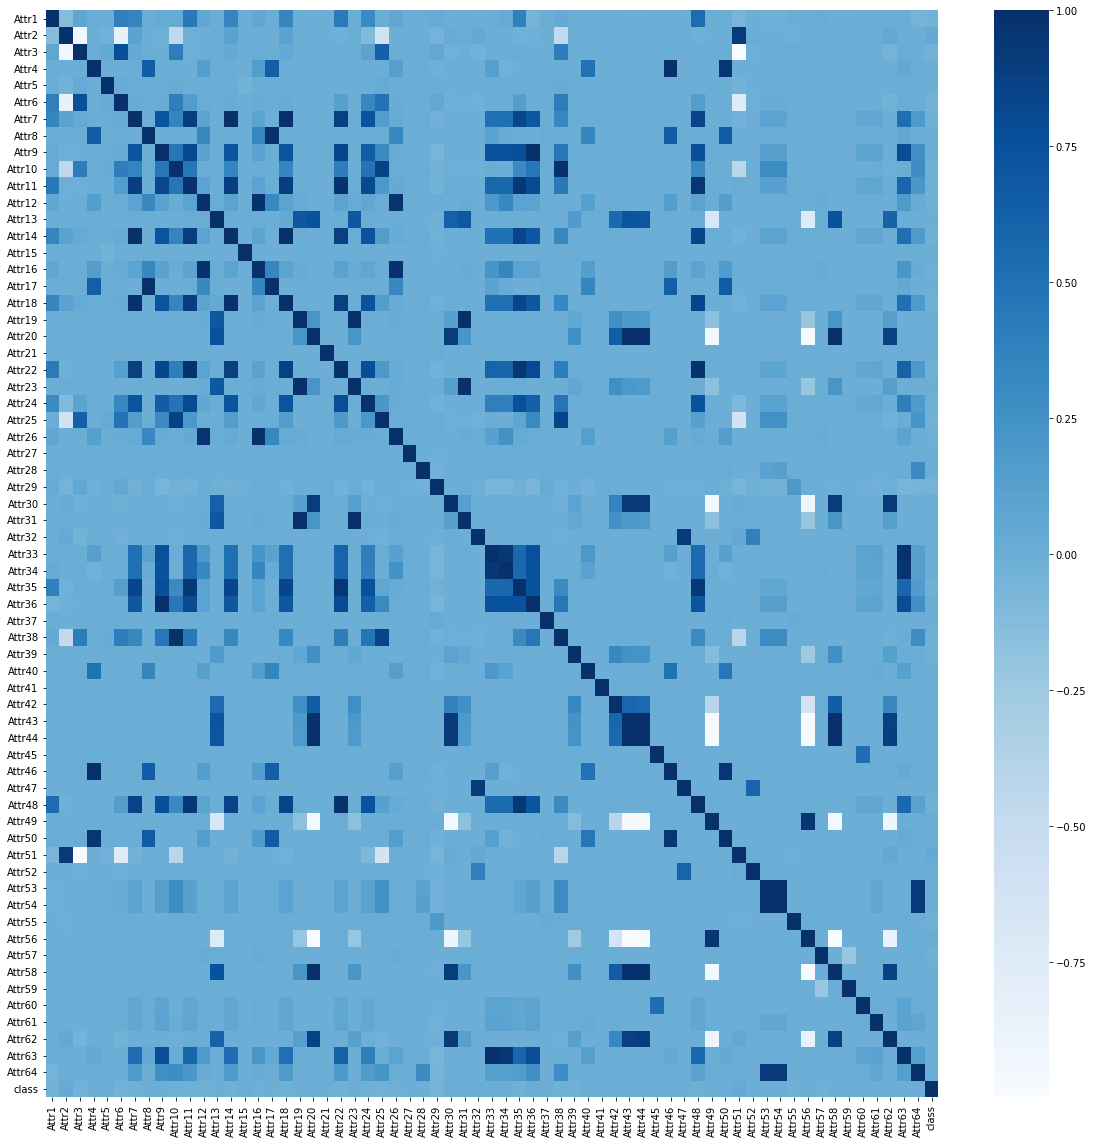

In [16]:
plt.figure(figsize=(20, 20))
sns.heatmap(data=df.corr(), cmap='Blues')
plt.show()

According to correlation plot, there is a lot of features with too high correlation and some features with strongly negative correlation values.

In [17]:
# Return dataframe with pairs of attributes and corresponding Kendall's tau value
# excluding pairs of 2 same attributes:

def corrank(matrix: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame([[(i, j), matrix.loc[i, j]] for i, j in list(itertools.combinations(matrix, 2))],
                        columns=['pairs', 'corr'])

In [18]:
# Below is the sorted list of attributes pairs and their correlation based on Kendall's tau value.

corr_matrix = df[df.columns.difference(['class'])].corr(method="kendall")
corr_matrix = corrank(corr_matrix)
print(corr_matrix.sort_values(by='corr', ascending=False))

                 pairs      corr
308   (Attr14, Attr18)  0.999863
360    (Attr14, Attr7)  0.999839
582    (Attr18, Attr7)  0.999702
1296  (Attr32, Attr52)  0.993930
529    (Attr17, Attr8)  0.970671
...                ...       ...
1275  (Attr32, Attr33) -0.988587
1333  (Attr33, Attr52) -0.994401
2001  (Attr62, Attr63) -0.995808
1709  (Attr44, Attr61) -0.997669
478    (Attr17, Attr2) -0.998801

[2016 rows x 2 columns]


In [19]:
print(corr_matrix[corr_matrix['corr'].between(0.8, 1, inclusive="both")].sort_values(by='corr', ascending=False)[0:10:1])

                 pairs      corr
308   (Attr14, Attr18)  0.999863
360    (Attr14, Attr7)  0.999839
582    (Attr18, Attr7)  0.999702
1296  (Attr32, Attr52)  0.993930
529    (Attr17, Attr8)  0.970671
123    (Attr10, Attr8)  0.962666
430   (Attr16, Attr26)  0.957736
60      (Attr1, Attr7)  0.940513
4      (Attr1, Attr14)  0.940374
8      (Attr1, Attr18)  0.940238


Pairs of features that have extremely high positive degree of association in range [0.8, 1]:

* X14 & X18
* X7 & X14
* X7 & X18
* X32 & X52
* X8 & X17
* X8 & X10
* X16 & X26
* X1 & X7
* X1 & X14
* X1 & X18

In [20]:
print(
    corr_matrix[corr_matrix['corr'].between(-1, -0.8, inclusive="both")].sort_values(by='corr', ascending=False)[10:0:-1])

                 pairs      corr
1333  (Attr33, Attr52) -0.994401
1275  (Attr32, Attr33) -0.988587
733   (Attr20, Attr60) -0.988286
688     (Attr2, Attr8) -0.969888
72     (Attr10, Attr2) -0.934448
1777  (Attr47, Attr60) -0.885471
1502  (Attr38, Attr51) -0.862671
1344  (Attr33, Attr62) -0.853195
1891  (Attr52, Attr63) -0.852701
1308  (Attr32, Attr63) -0.852374


Pairs of features that have extremely negative degree of association in range [-1, -0.8]:

* X33 & X52
* X32 & X33
* X20 & X60
* X2 & X8
* X2 & X10
* X47 & X60
* X38 & X51
* X33 & X62
* X52 & X63
* X32 & X63

Features to keep should be in range [-0.8, 0.8] based on Kendall coefficient values:

In [21]:

columns_name = set(df.columns)

columns_name.difference_update(
    [corr[0] for corr in corr_matrix[corr_matrix['corr'].between(-1, -0.8, inclusive="neither")]['pairs']])
columns_name.difference_update(
    [corr[1] for corr in corr_matrix[corr_matrix['corr'].between(-1, -0.8, inclusive="neither")]['pairs']])
columns_name.difference_update(
    [corr[0] for corr in corr_matrix[corr_matrix['corr'].between(0.8, 1, inclusive="neither")]['pairs']])
columns_name.difference_update(
    [corr[1] for corr in corr_matrix[corr_matrix['corr'].between(0.8, 1, inclusive="neither")]['pairs']])
columns_name = list(columns_name)
columns_name

['Attr30',
 'Attr12',
 'Attr45',
 'Attr29',
 'Attr9',
 'Attr43',
 'Attr34',
 'Attr6',
 'Attr24',
 'class',
 'Attr21',
 'Attr59',
 'Attr4',
 'Attr15',
 'Attr57',
 'Attr46',
 'Attr13',
 'Attr40',
 'Attr41',
 'Attr37',
 'Attr55',
 'Attr27',
 'Attr64',
 'Attr5',
 'Attr50',
 'Attr36',
 'Attr25']

In [22]:
df = df[columns_name]

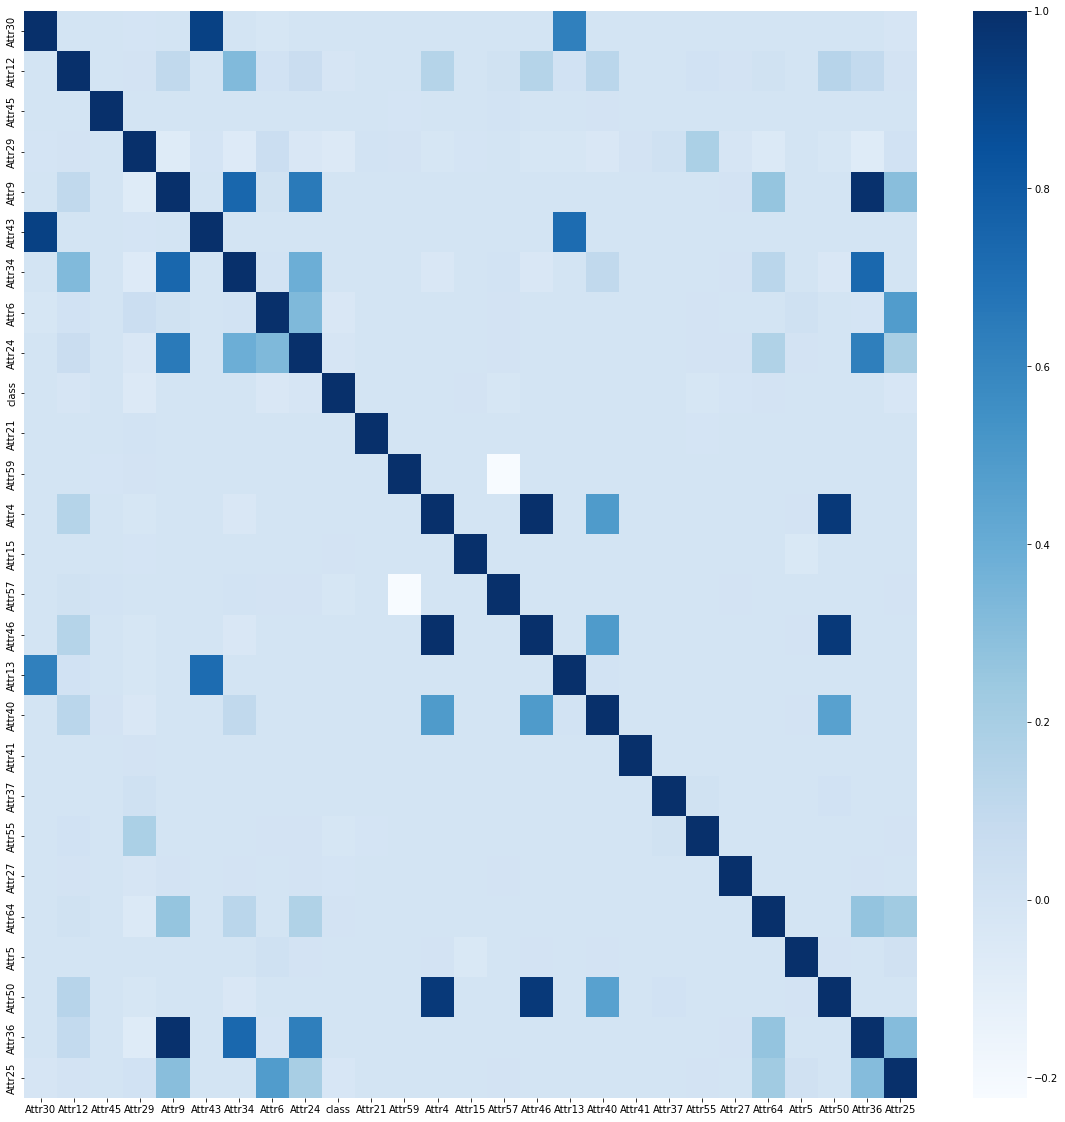

In [23]:
plt.figure(figsize=(20, 20))
sns.heatmap(data=df.corr(), cmap='Blues')
plt.show()

In [24]:
def features_target_relationship_plot(features: list[str]) -> None:
    sns.pairplot(
        data=df,
        y_vars=['class'],
        x_vars=features,
        hue='class',
        palette='Dark2',
        diag_kind='kde',
        plot_kws={
            'alpha': 0.6,
            's': 80,
            'edgecolor': 'k'
        },
        height=4
    )
    plt.show()

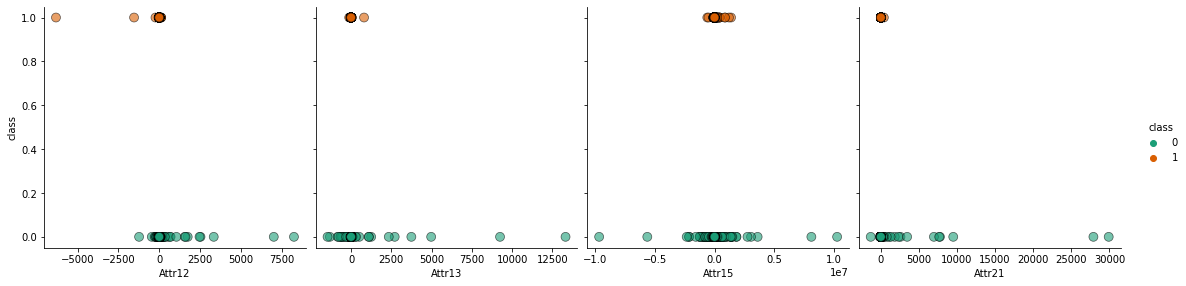

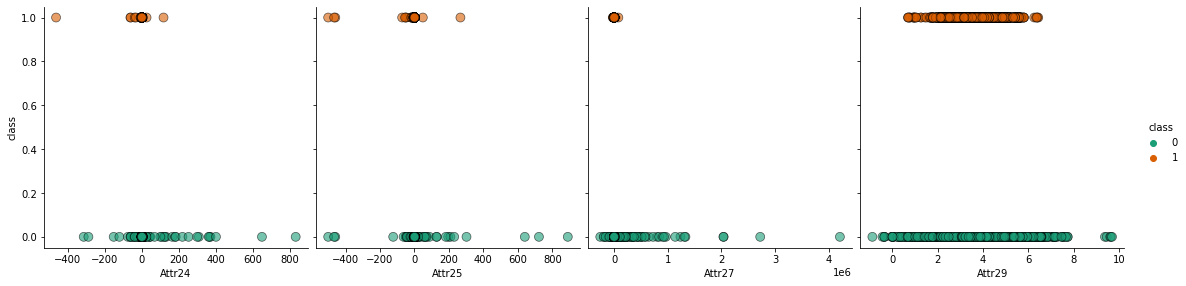

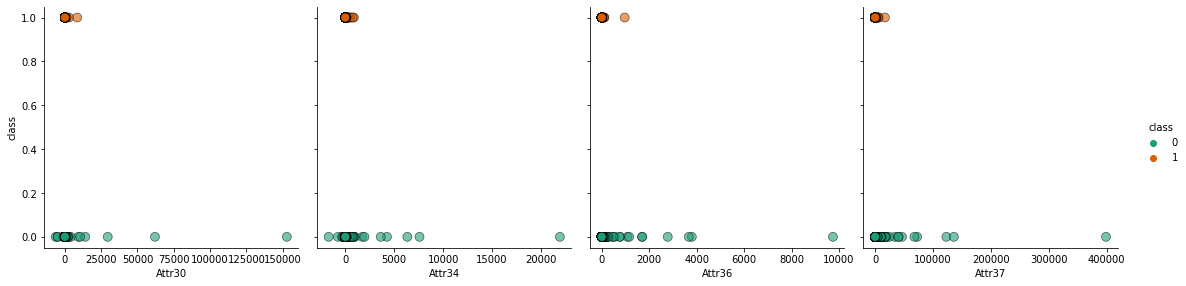

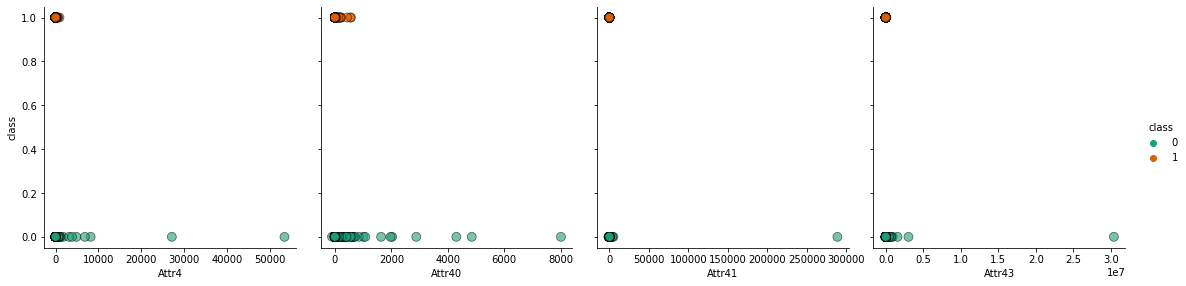

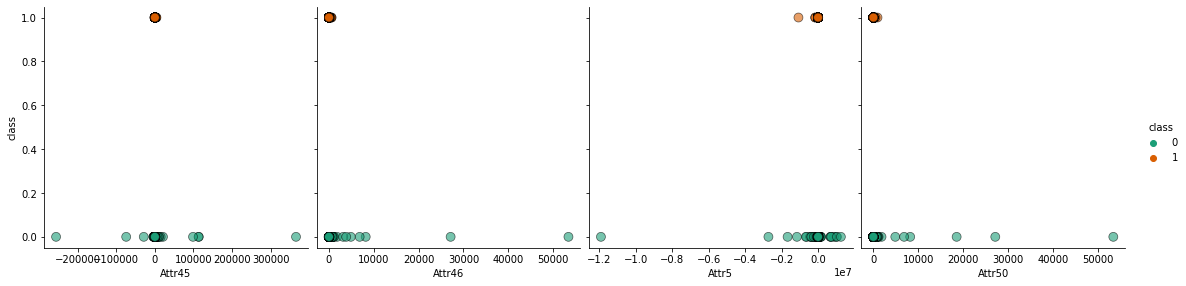

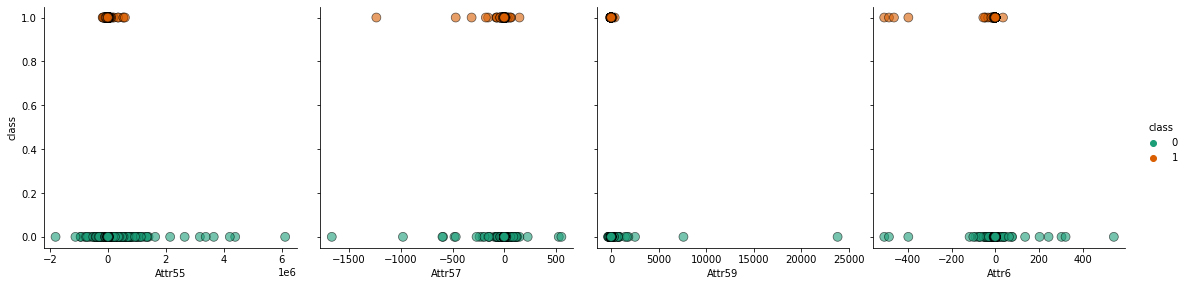

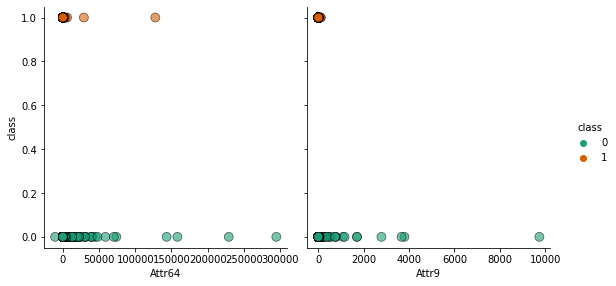

In [25]:
# Now a better look between the target and some of the features we want to explore
features_lst1 = ['Attr12', 'Attr13', 'Attr15', 'Attr21']
features_lst2 = ['Attr24', 'Attr25', 'Attr27', 'Attr29']
features_lst3 = ['Attr30', 'Attr34', 'Attr36', 'Attr37']
features_lst4 = ['Attr4', 'Attr40', 'Attr41', 'Attr43']
features_lst5 = ['Attr45', 'Attr46', 'Attr5', 'Attr50']
features_lst6 = ['Attr55', 'Attr57', 'Attr59', 'Attr6']
features_lst7 = ['Attr64', 'Attr9']
lst = [features_lst1, features_lst2, features_lst3, features_lst4,
       features_lst5, features_lst6, features_lst7]

for i in lst:
    features_target_relationship_plot(i)


From the previous figures which consist of pairplots between the target and the features we can see the relationship between the target classes(0,1) and each feature independently

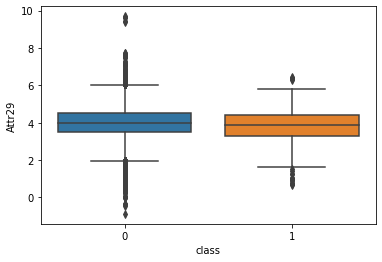

In [26]:
# making a boxplot between the target and Attr29
sns.boxplot(x='class', y='Attr29', data=df)
plt.show()


In [27]:
plot_col = 4
plot_rows = int((df.shape[1] - 1) / 4)


# creates subplot for feature distributions + stats
def plot_dist_df(df: pd.DataFrame) -> None:
    tmp_drop = df.dropna()
    fig, ax = plt.subplots(plot_rows, plot_col, sharex=False, sharey=False, figsize=(12, 75))
    for j in range(plot_col * plot_rows):
        column_name = columns_name[j]
        row_index = int(j / plot_col)
        col_index = j % plot_col

        feature = np.array(tmp_drop[column_name].values)
        tmp_ax = ax[row_index][col_index]
        tmp_ax.set_title(column_name)

        mean_txt = f"Mean: {round(feature.mean(), 4)}"
        tmp_ax.text(0.5, -0.12, mean_txt, size=11, ha="center", transform=tmp_ax.transAxes)

        var_txt = f"STD: {round(feature.std(), 4)}"
        tmp_ax.text(0.5, -0.22, var_txt, size=11, ha="center", transform=tmp_ax.transAxes)

        skew_text = f"Skew: {round(skew(feature), 4)}"
        tmp_ax.text(0.5, -0.32, skew_text, size=11, ha="center", transform=tmp_ax.transAxes)

        kurtosis_txt = f"Kurtosis: {round(kurtosis(feature), 4)}"
        tmp_ax.text(0.5, -0.42, kurtosis_txt, size=11, ha="center", transform=tmp_ax.transAxes)

        sns.distplot(feature, label=column_name, ax=tmp_ax)

    fig.tight_layout()
    plt.show()

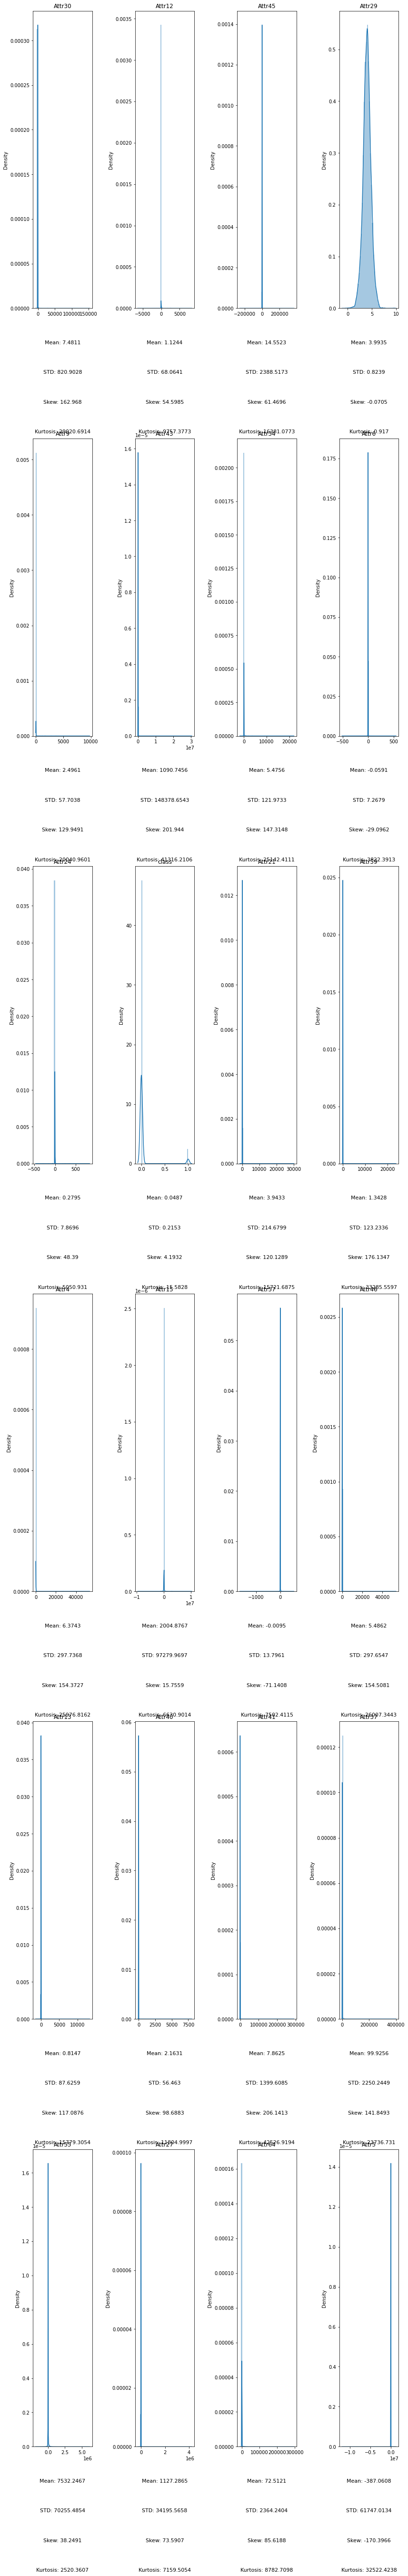

In [28]:
# plot feature distributions and stats 
plot_dist_df(df)

***Dealing with imbalanced data***

In [29]:
X = df[df.columns.difference(['class'])]
Y = df['class']

In [30]:
sm = SMOTE(random_state=111)
X_smote, y_smote = sm.fit_resample(X, Y)

In [31]:
# Splitting the data after balancing
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.3)

In [32]:
# Normalizing the features
min_max_scaler = preprocessing.MinMaxScaler()
X_train_smote_scaled = min_max_scaler.fit_transform(X_train_smote)
y_test_smote_scaled = min_max_scaler.fit_transform(X_test_smote)

***Modeling***

In [33]:
def save_model(model: any, features: np.ndarray, label: pd.Series, out_dir: str) -> None:
    model.fit(features, label)
    pickle.dump(model, open(out_dir, 'wb'))


def validate(in_dir: str, X_test: np.ndarray, y_test: pd.Series, title: str) -> None:
    model = pickle.load(open(in_dir, 'rb'))
    y_probas = model.predict_proba(X_test)
    plot_precision_recall(
        y_test,
        y_probas,
        title=f"Precision-recall curve {title}"
    )
    plt.show()

Save models:

* Random forest classifier with data balanced with SMOTE
* Naive Bayes classifier with data balanced with SMOTE 
* XGBoost classifier with data balanced with SMOTE 


In [34]:
train_models = [
    (RandomForestClassifier(), X_train_smote_scaled, y_train_smote, 'models/random_forest_SMOTE.pkl'),
    (GaussianNB(), X_train_smote_scaled, y_train_smote, 'models/gaussian_nb_SMOTE.pkl'),
    (xgboost.XGBClassifier(), X_train_smote_scaled, y_train_smote, 'models/xgboost_SMOTE.pkl')
]

for clr, features, label, out_dir in train_models:
    save_model(clr, features, label, out_dir)

[17:02:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Validate models on the hold-out (30% of sample):

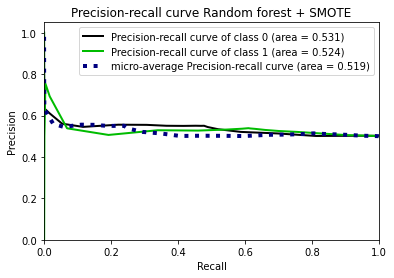

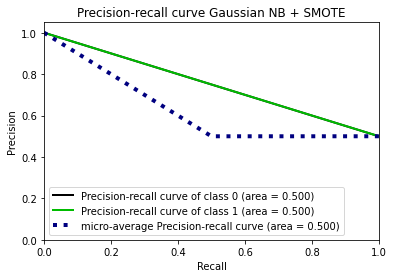

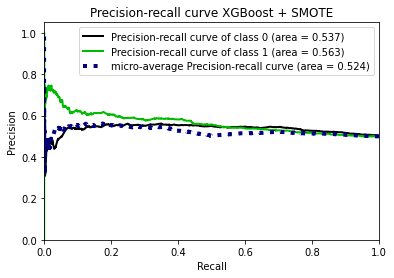

In [35]:
test_models = [
    ('models/random_forest_SMOTE.pkl', y_test_smote_scaled, y_test_smote, 'Random forest + SMOTE'),
    ('models/gaussian_nb_SMOTE.pkl', y_test_smote_scaled, y_test_smote, 'Gaussian NB + SMOTE'),
    ('models/xgboost_SMOTE.pkl', y_test_smote_scaled, y_test_smote, 'XGBoost + SMOTE')
]

for in_dir, X_test, y_test, title in test_models:
    validate(in_dir, X_test, y_test, title)

Results:

* Random forest classifier with default parameters run on oversampled and imputed data (SMOTE) leads to micro-average AUC around 0.502, the algorithm performs poorly.
* Naive Bayes classifier performs poorly on oversampled and imputed data (SMOTE), AUC = 0.5
* XGBoost classifier also performs poorly to the data oversampled with SMOTE and imputed data leads to the mirco-average precision-recall rate only 0.474, and there is a high risk that this model is underfitted

According to the results, it is necessary to tune parameters for random forest classifier to avoid overfitting.

run grid search (5 folds) for tuning maximum depth of the tree estimator, and compare: a) random forest classifier, b) AdaBoost classifier.

In [36]:
# Run grid search on random forest
param_grid = {
    'max_depth': [3, 5, 7, 8]
}

In [37]:
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)
CV_rfc.fit(X_smote, y_smote)

CV_rfc.best_params_

{'max_depth': 8}

In [38]:
# Run grid search on AdaBoost

param_grid = {'base_estimator__max_depth': [3, 5, 7, 10],
              'base_estimator': [DecisionTreeClassifier()]}

CV_rfc = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, cv=5)
CV_rfc.fit(X_smote, y_smote)

CV_rfc.best_params_

{'base_estimator': DecisionTreeClassifier(max_depth=10),
 'base_estimator__max_depth': 10}

In [39]:
train_models = [
    (RandomForestClassifier(max_depth=8), X_train_smote, y_train_smote, 'models/random_forest2_SMOTE.pkl'),
    (AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10)), X_train_smote, y_train_smote,
     'models/adaboost_SMOTE.pkl')
]

for clr, features, label, out_dir in train_models:
    save_model(clr, features, label, out_dir)

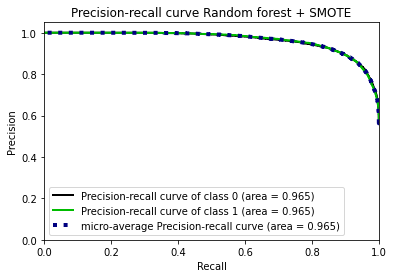

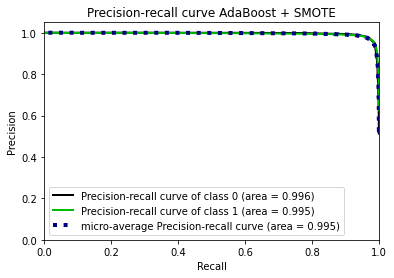

In [40]:
test_models = [
    ('models/random_forest2_SMOTE.pkl', X_test_smote, y_test_smote, 'Random forest + SMOTE'),
    ('models/adaboost_SMOTE.pkl', X_test_smote, y_test_smote, 'AdaBoost + SMOTE')
]

for in_dir, X_test, y_test, title in test_models:
    validate(in_dir, X_test, y_test, title)

* As it is seen from the two plots above, AdaBoost classifier is likely to be overfitted on oversampled (SMOTE) data.
* The best classifier is random forest that was fitted on oversampled (SMOTE) data with preliminarly dropped missing values, area under the precision-recall curve is 0.965